Deep dive into price analysis. Mainly spot and intraday prices. Look at min, max, avg for every hour in intraday.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [3]:
data_folder_path = os.path.join(os.path.dirname(os.getcwd()), 'data_23')
data_files_path = os.listdir(data_folder_path)

In [ ]:
data_da = pd.DataFrame()
data_id = pd.DataFrame()
corrupted_data = []

for file_path in data_files_path:

    data_file_path = os.path.join(data_folder_path,file_path)

    try:
        single_day_data = pd.read_csv(data_file_path, sep=';', skiprows=1, header=None, encoding = 'latin-1')
        single_day_data = single_day_data.iloc[:-1,:-1] # filtering out last row and columns which are blank

        if file_path.split('_')[0] == 'marginalpdbc':

            single_day_data.columns = ['Year','Month','Day','Hour','DA PT','DA ES'] # changing column names
            cols = list(range(4)) + [5] #selecting only dates and Spain data columns
            

            if len(single_day_data) == 24:
                data_da = pd.concat([data_da,single_day_data.iloc[:,cols]])
            elif len(single_day_data) > 24:
                data_da = pd.concat([data_da,single_day_data.iloc[:-1,cols]])
            elif len(single_day_data) < 24:
                hour_to_add = single_day_data.iloc[-1].copy()
                hour_to_add.iloc[4:] = np.nan
                hour_to_add.iloc[3] = 24
                single_day_data_corrected = pd.concat([single_day_data,hour_to_add.to_frame().T])
                data_da = pd.concat([data_da,single_day_data_corrected.iloc[:,cols]])

        else:
            single_day_data.columns = ['Year','Month','Day','Hour','MaxES','MaxPT','MaxMO','MinES','MinPT','MinMO','AvgES','AvgPT','AvgMO']
            single_day_data = single_day_data.iloc[1:] # removing first row which are old headers not values
            cols = list(range(5)) + [7, 10] #selecting only dates and Spain data columns

            if len(single_day_data) == 24:
                data_id = pd.concat([data_id,single_day_data.iloc[:,cols]])
            elif len(single_day_data) > 24:
                data_id = pd.concat([data_id,single_day_data.iloc[:-1,cols]])
            elif len(single_day_data) < 24:
                # copying last hour data to missing hour 24
                hour_to_add = single_day_data.iloc[-1].copy()
                hour_to_add.iloc[4:] = np.nan
                hour_to_add.iloc[3] = 24
                single_day_data_corrected = pd.concat([single_day_data,hour_to_add.to_frame().T])
                data_id = pd.concat([data_id,single_day_data_corrected.iloc[:,cols]])

        if len(single_day_data) != 24:
            print(f'Hours recorded in {file_path}:', len(single_day_data))
            corrupted_data.append(single_day_data)



    except Exception as e:
        print(e)
        print(f'Error in file {file_path}')


# Intraday market dataset given with commas - changing to '.' float
data_id.iloc[:,4:] = data_id.iloc[:,4:].replace(',','.',regex=True).astype(float)

# Change dates to str for consistency with data_id
data_da[['Year', 'Month', 'Day', 'Hour']] = data_da[['Year', 'Month', 'Day', 'Hour']].astype(int)
data_da[['Year', 'Month', 'Day', 'Hour']] = data_da[['Year', 'Month', 'Day', 'Hour']].astype(str)



Hours recorded in marginalpdbc_20230326.1.csv: 23
Hours recorded in precios_pibcic_20231029.1.csv: 25
Hours recorded in precios_pibcic_20230326.1.csv: 23
Hours recorded in marginalpdbc_20231029.1.csv: 25


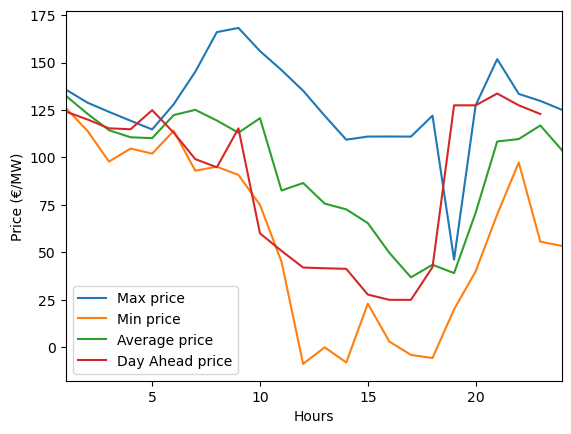

In [120]:
def plot_day_prices(year:str, month:str, day:str):
    intraday = data_id[(data_id["Year"] == year) & (data_id["Month"] == month) & (data_id["Day"] == day)]
    day_ahead = data_da[(data_da["Year"] == year) & (data_da["Month"] == month) & (data_da["Day"] == day)]

    plt.plot(intraday["MaxES"], label="Max price")
    plt.plot(intraday["MinES"], label="Min price")
    plt.plot(intraday["AvgES"], label="Average price")
    plt.plot(day_ahead["DA ES"], label="Day Ahead price")

    plt.xlim(left= 1, right=24)
    plt.margins(y=0.05)

    plt.ylabel('Price (€/MW)')
    plt.xlabel('Hours')

    plt.legend()
    plt.show()

plot_day_prices("2023", "4", "6")

In [96]:
def check_labels(data_id):
    wrong_labels = data_id[(data_id["AvgES"] > data_id["MaxES"]) | (data_id["AvgES"] < data_id["MinES"])]
    if wrong_labels.empty:
        print("All labels are correct")
    return wrong_labels 

wrong_labels = check_labels(data_id)


All labels are correct


In [104]:
def combine_dataframes(data_da, data_id):
    return data_id.merge(data_da[["Year", "Month", "Day", "Hour", "DA ES"]], on=["Year", "Month", "Day", "Hour"], how="left")

In [113]:
combined_data = combine_dataframes(data_da, data_id)
# Add spread of average intraday price and day ahead price
combined_data["Spread"] = (combined_data["DA ES"] - combined_data["AvgES"]).astype(float)

In [119]:
# Get largest positive and negative spreads
negative_spread = combined_data.nlargest(12, "Spread")
positive_spread = combined_data.nsmallest(12, "Spread")

biggest_negative_spread_days = combined_data.merge(
    negative_spread[['Year', 'Month', 'Day']].drop_duplicates(), 
    on=['Year', 'Month', 'Day'], 
    how='inner'
)


# Print the result
print(biggest_negative_spread_days)

     Year Month Day Hour   MaxES   MinES   AvgES   DA ES  Spread
0    2023     4   6    1  135.74   126.0  132.47  135.54    3.07
1    2023     4   6    2  128.85  114.01  123.01  124.12    1.11
2    2023     4   6    3   124.0   97.82  114.33   120.0    5.67
3    2023     4   6    4  119.33  104.69  110.61  115.33    4.72
4    2023     4   6    5  114.75   102.0  110.17  114.85    4.68
..    ...   ...  ..  ...     ...     ...     ...     ...     ...
211  2023    12   1   20  162.11   69.79  100.91   107.0    6.09
212  2023    12   1   21   135.0    71.1   97.72  107.17    9.45
213  2023    12   1   22  123.32    59.8    95.6   105.0    9.40
214  2023    12   1   23  114.92    15.0   76.99    98.4   21.41
215  2023    12   1   24  106.76     5.0    68.6    86.1   17.50

[216 rows x 9 columns]


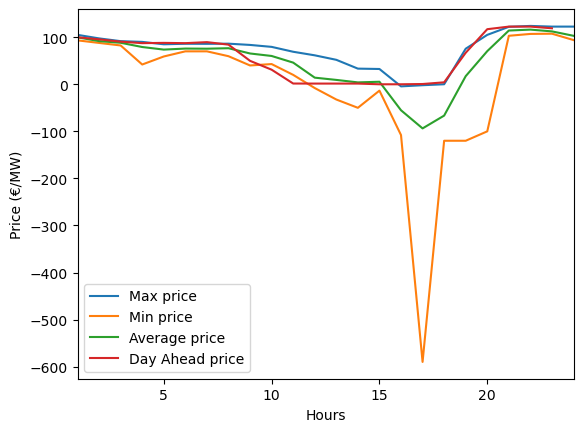

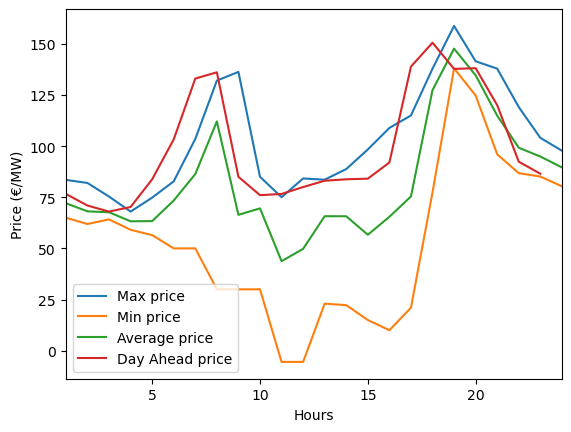

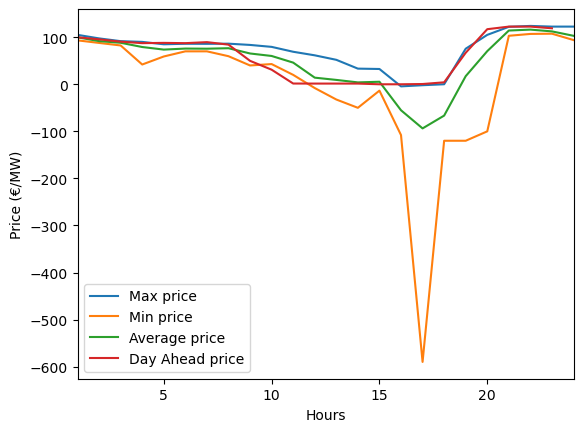

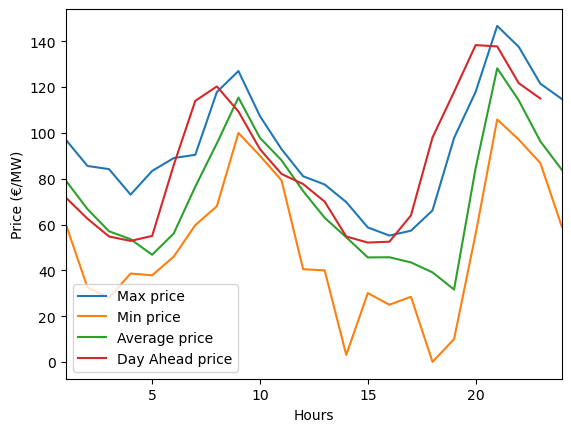

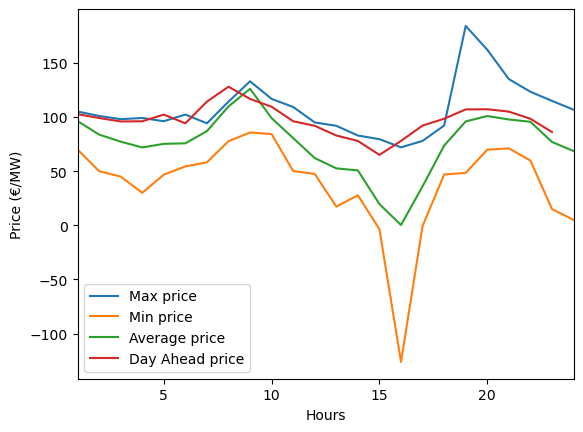

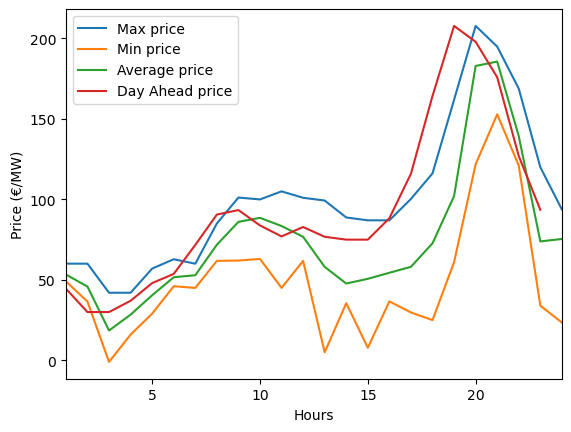

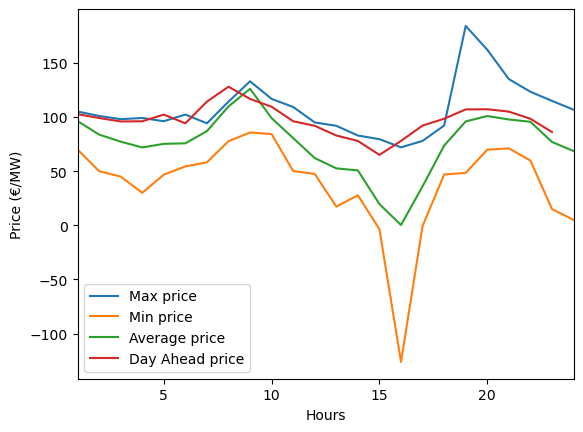

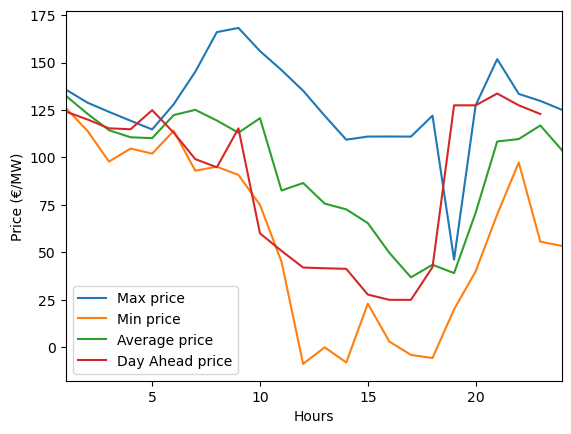

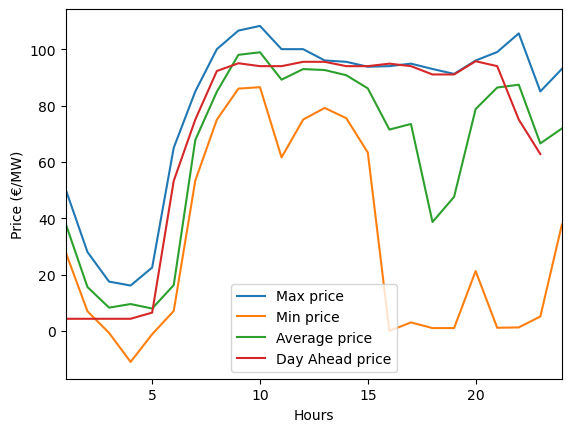

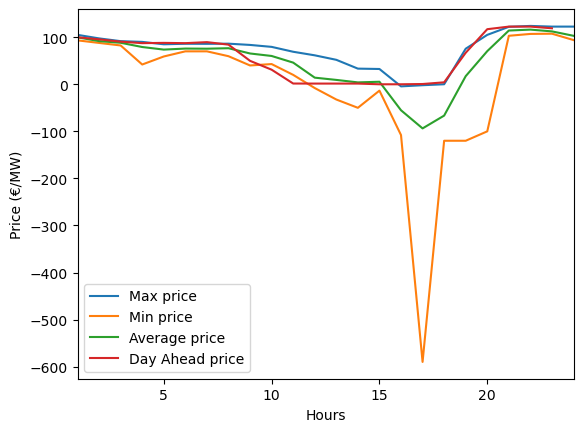

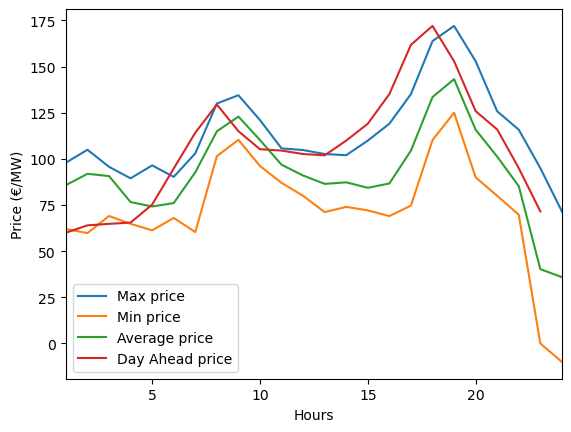

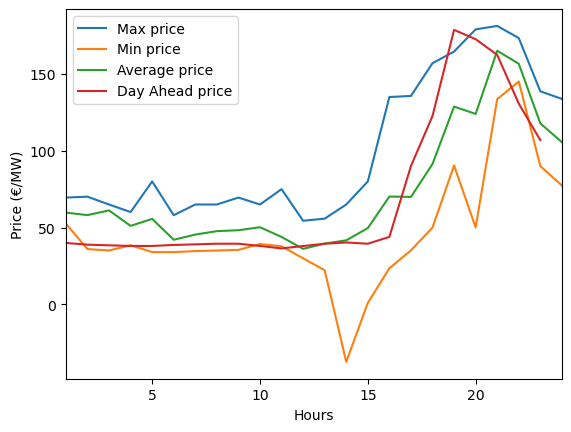

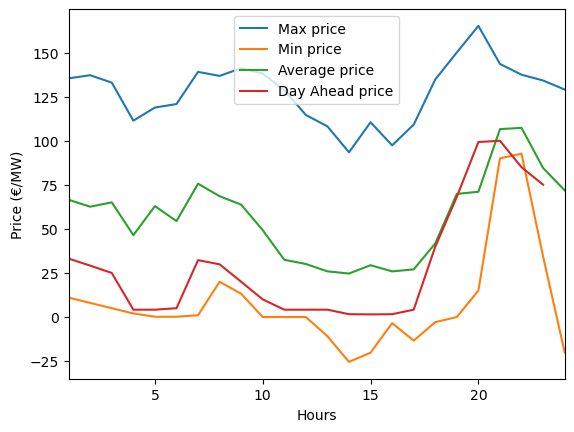

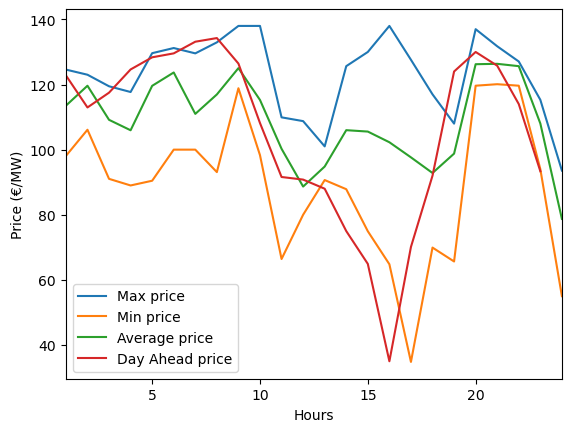

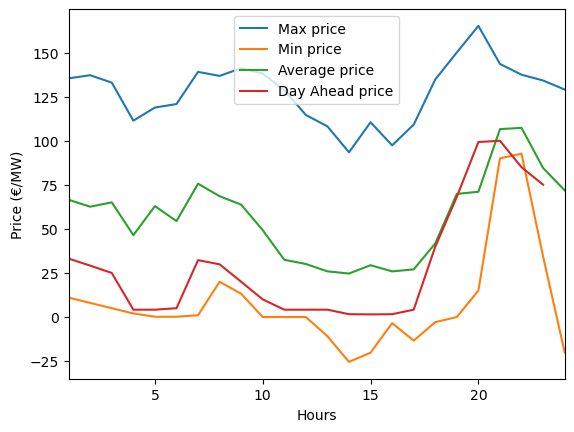

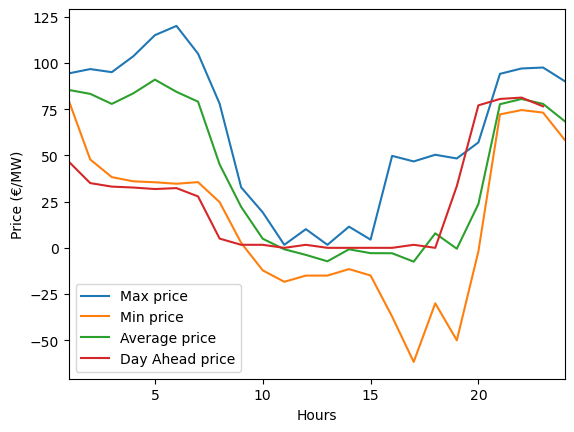

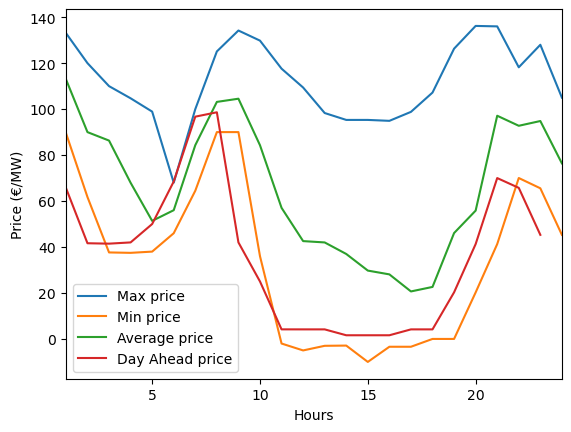

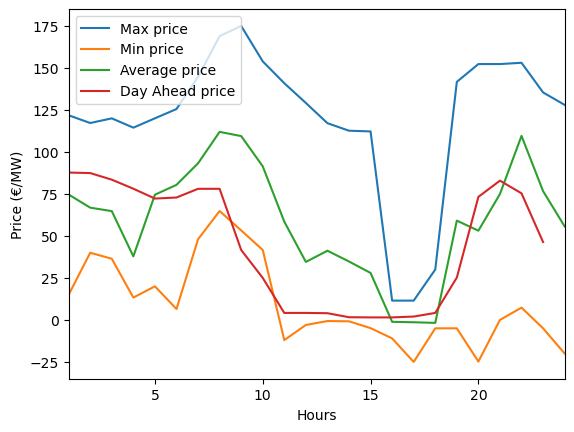

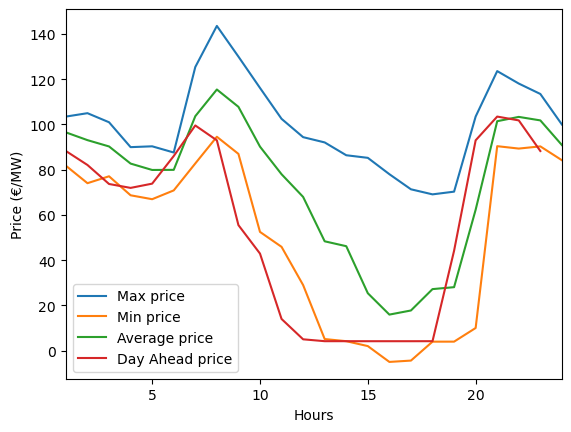

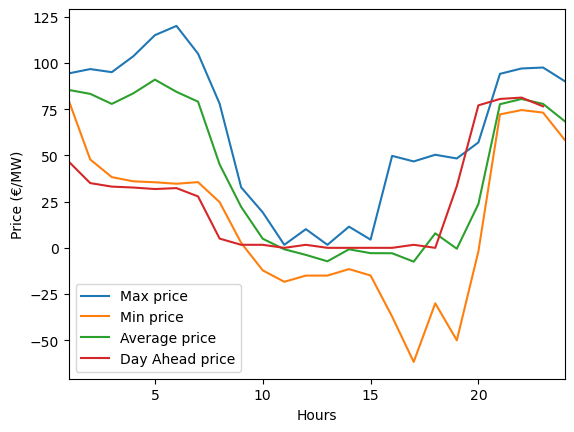

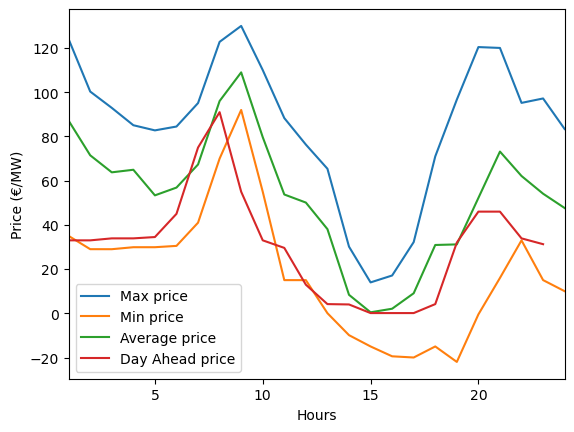

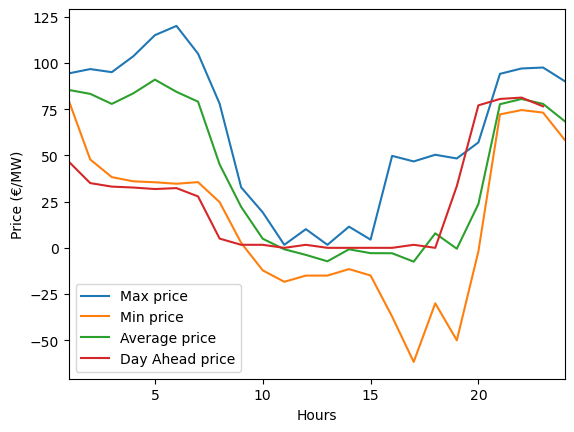

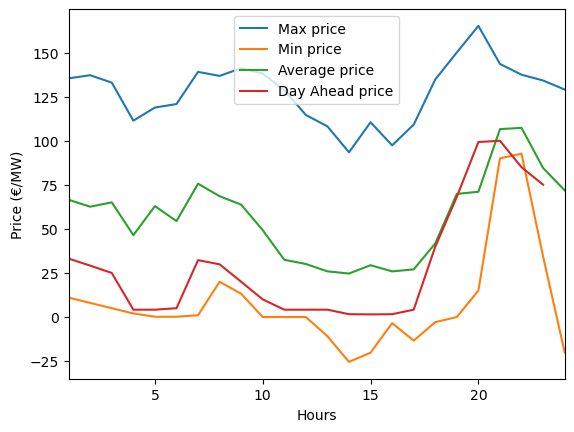

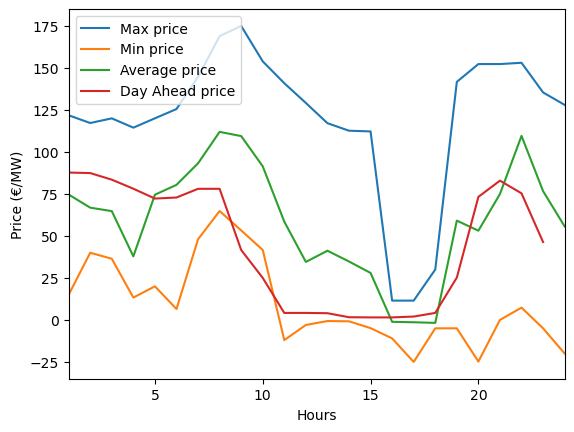

In [124]:
for index, row in negative_spread.iterrows():
    plot_day_prices(row["Year"], row["Month"], row["Day"])

for index, row in positive_spread.iterrows():
    plot_day_prices(row["Year"], row["Month"], row["Day"])
